# Example 1: Preprocessing Workflow

This is meant as a very simple example for a preprocessing workflow. In this workflow we will conduct the following steps:

1. Motion correction of functional images with FSL's MCFLIRT
2. Coregistration of functional images to anatomical images (according to FSL's FEAT pipeline)
3. Smoothing of coregistered functional images with FWHM set to 4mm and 8mm
4. Artifact Detection in functional images (to detect outlier volumes)

## Preparation

Before we can start with anything we first need to download the data (the other 9 subjects in the dataset). This can be done very quickly with the following `datalad` command.

**Note:** This might take a while, as datalad needs to download ~700MB of data

In [1]:
%%bash
datalad get -J 4 -d /home/neuro/workshop/data/ds000114 \
    /home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-*/anat/*preproc.nii.gz \
    /home/neuro/workshop/data/ds000114/sub-*/ses-test/func/*fingerfootlips*

action summary:
  get (notneeded: 31)


It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.
It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


## Inspect the data

For every subject we have one anatomical T1w and 5 functional images. As a short recap, the image properties of the anatomy and the **fingerfootlips** functional image are:

In [2]:
%%bash
cd /home/neuro/workshop/data/ds000114/
nib-ls derivatives/fmriprep/sub-01/anat/*t1w_preproc.nii.gz sub-01/ses-test/f*/*fingerfootlips*.nii.gz

derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz           float32 [256, 156, 256]      1.00x1.30x1.00        sform
sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz  int16  [ 64,  64,  30, 184] 4.00x4.00x4.00x2.50   sform



**So, let's start!**

## Imports

First, let's import all the modules we later will be needing.

In [3]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import Smooth
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype import Workflow, Node

## Experiment parameters

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. We will use one functional image for fingerfootlips task for ten subjects.

In [4]:
experiment_dir = '/output'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10']

# list of session identifiers
task_list = ['fingerfootlips']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
with open('/home/neuro/workshop/data/ds000114/task-fingerfootlips_bold.json', 'rt') as fp:
    task_info = json.load(fp)
TR = task_info['RepetitionTime']

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

## Specify Nodes for the main workflow

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [5]:
# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
               name="extract")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")

# SliceTimer - correct for slice wise acquisition
slicetimer = Node(SliceTimer(index_dir=False,
                             interleaved=True,
                             output_type='NIFTI',
                             time_repetition=TR),
                  name="slicetimer")

# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")

## Coregistration Workflow

Initiate a workflow that coregistrates the functional images to the anatomical image (according to FSL's FEAT pipeline).

In [6]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

## Specify input & output stream

Specify where the input data can be found & where and how to save the output data.

In [7]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('derivatives', 'fmriprep', 'sub-{subject_id}', 'anat', 'sub-{subject_id}_t1w_preproc.nii.gz')
func_file = opj('sub-{subject_id}', 'ses-test', 'func',
                'sub-{subject_id}_ses-test_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/home/neuro/workshop/data/ds000114'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [8]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, extract, [('func', 'in_file')]),
                 (extract, mcflirt, [('roi_file', 'in_file')]),
                 (mcflirt, slicetimer, [('out_file', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (slicetimer, coregwf, [('slice_time_corrected_file', 'applywarp.in_file')]),
                 
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

## Visualize the workflow

It always helps to visualize your workflow.

211018-10:44:02,519 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


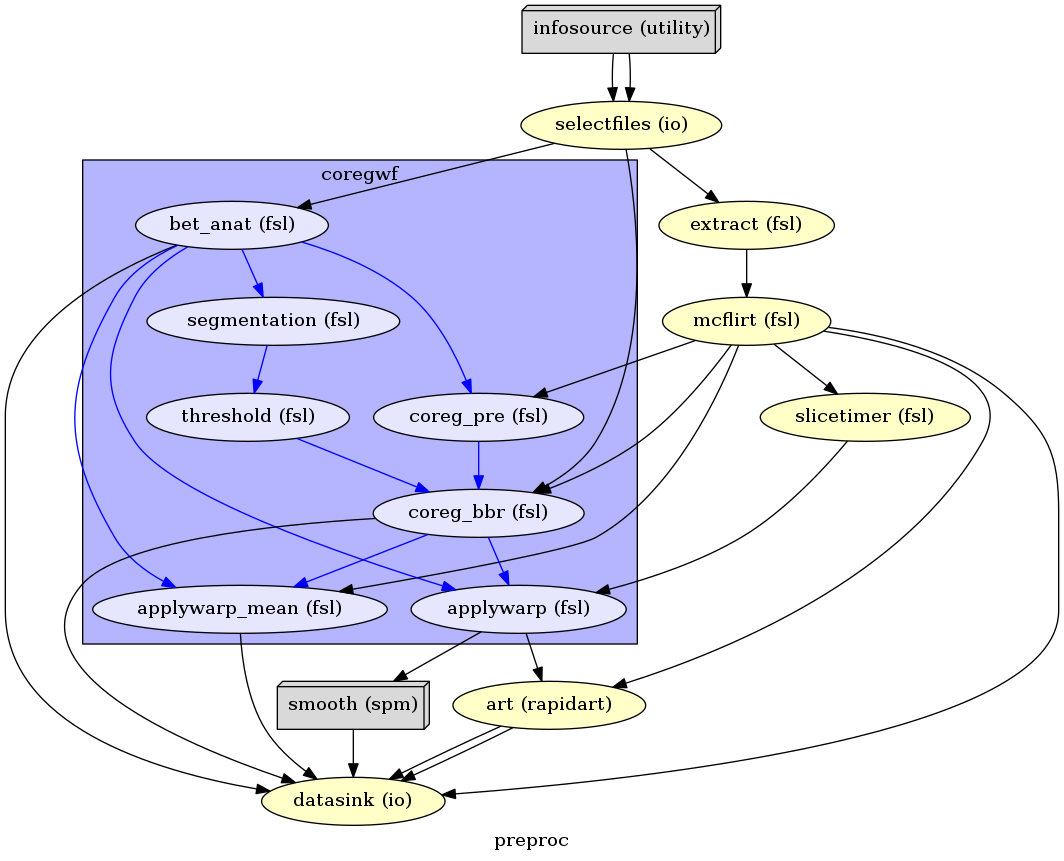

In [9]:
# Create preproc output graph
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

211018-10:44:03,57 nipype.workflow INFO:
	 Generated workflow graph: /output/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


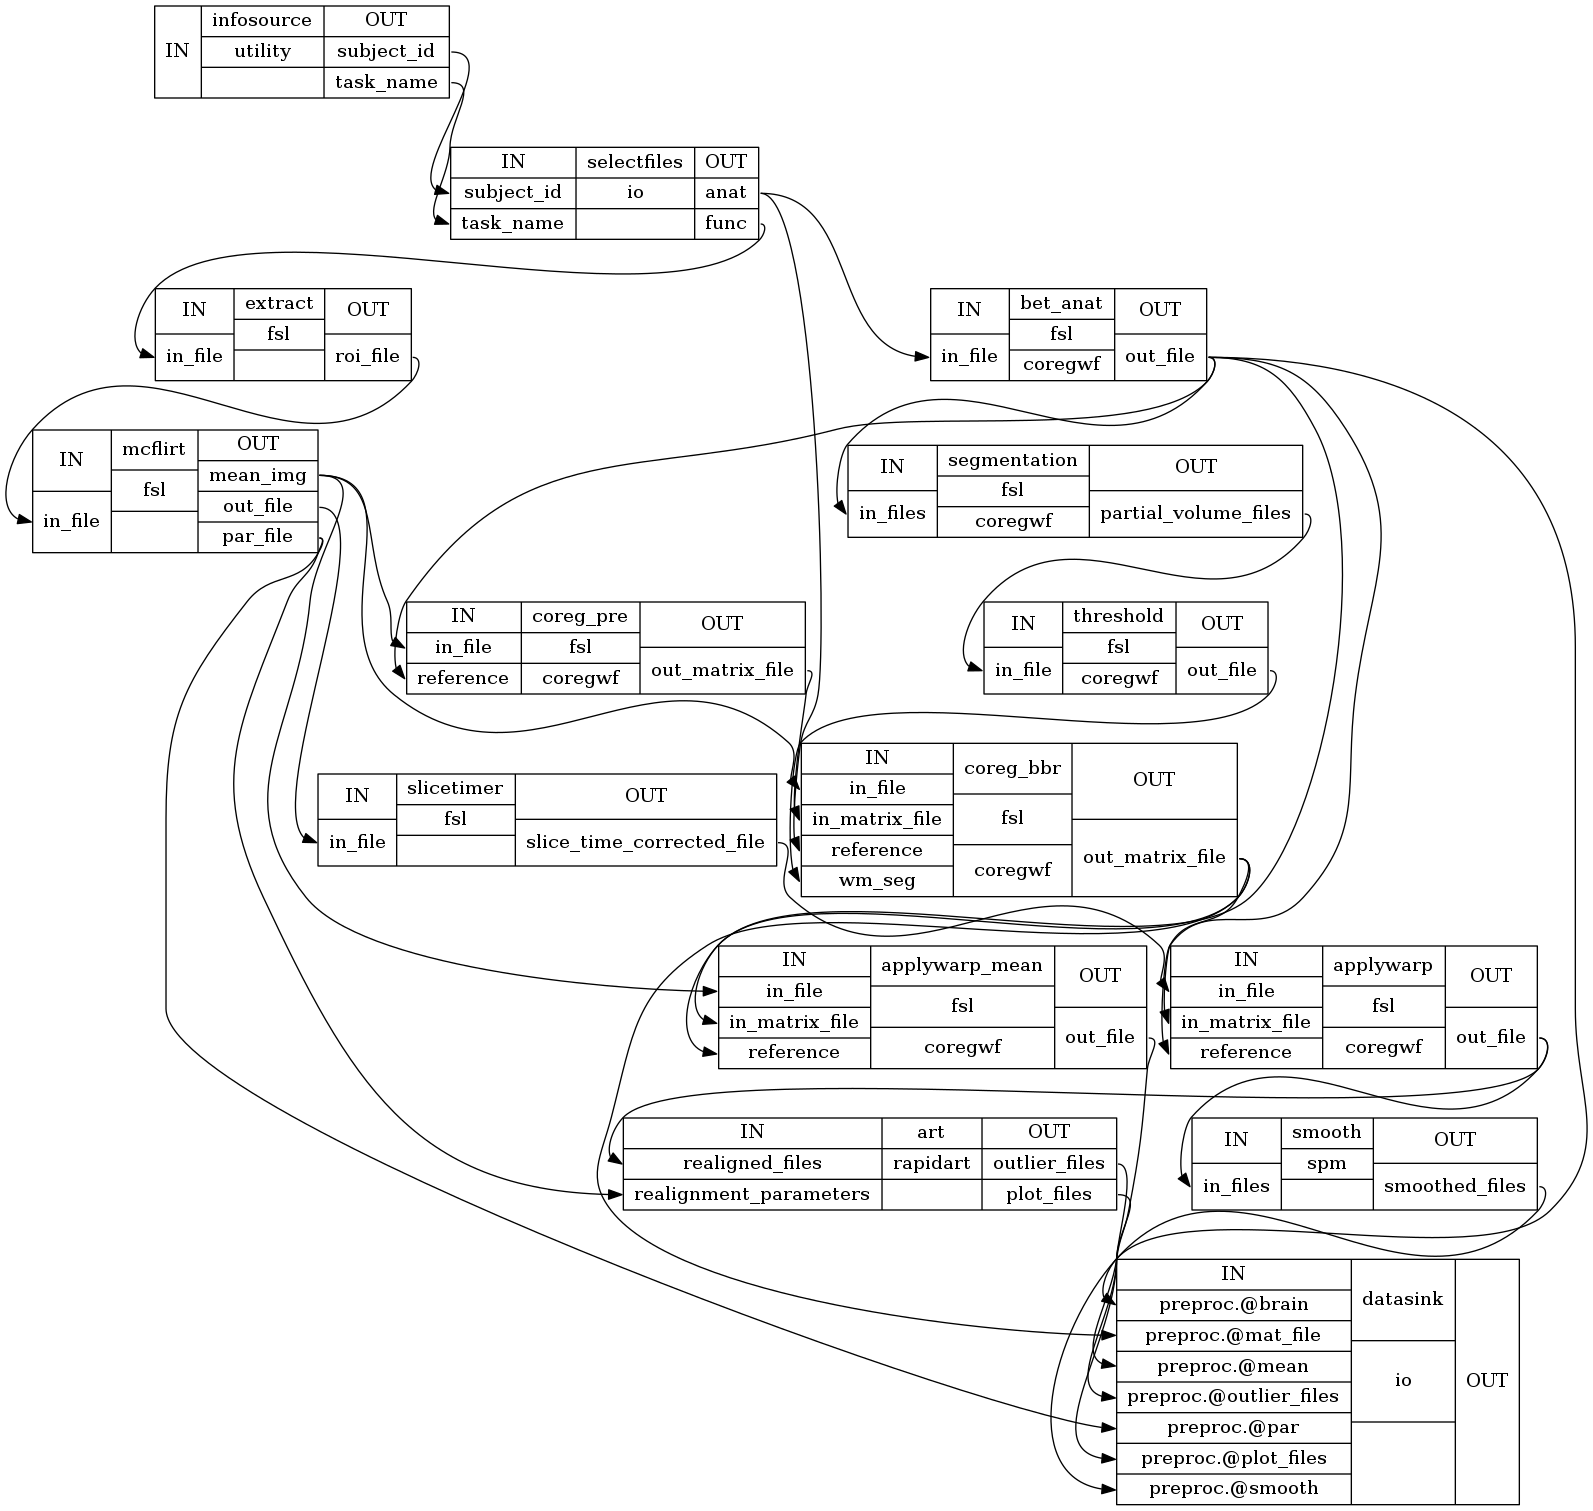

In [10]:
# Visualize the detailed graph
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

##  Run the Workflow

Now that everything is ready, we can run the preprocessing workflow. Change ``n_procs`` to the number of jobs/cores you want to use. **Note** that if  you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [11]:
preproc.run('MultiProc', plugin_args={'n_procs': 4})

211018-10:44:03,104 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
211018-10:44:03,244 nipype.workflow INFO:
	 Running in parallel.
211018-10:44:03,254 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 10 jobs ready. Free memory (GB): 5.23/5.23, Free processors: 4/4.
211018-10:44:03,364 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_09_task_name_fingerfootlips/selectfiles".
211018-10:44:03,364 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_08_task_name_fingerfootlips/selectfiles".
211018-10:44:03,364 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_07_task_name_fingerfootlips/selectfiles".
211018-10:44:03,364 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/output/workingdir/preproc/_subject_id_10_task_name_fingerfootlips/selectfiles

211018-10:44:23,308 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 0.63/5.23, Free processors: 0/4.
                     Currently running:
                       * preproc.coregwf.bet_anat
                       * preproc.coregwf.segmentation
                       * preproc.mcflirt
                       * preproc.mcflirt
211018-10:44:38,642 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.bet_anat".
211018-10:44:39,310 nipype.workflow INFO:
	 [Job 33] Completed (preproc.coregwf.bet_anat).
211018-10:44:39,314 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 0.83/5.23, Free processors: 1/4.
                     Currently running:
                       * preproc.coregwf.segmentation
                       * preproc.mcflirt
                       * preproc.mcflirt
211018-10:44:39,389 nipype.workflow INFO:
	 [Node] Setting-up "preproc.extract" in "/output/workingdir/preproc/_subject_id_08_task_na

211018-10:45:46,400 nipype.workflow INFO:
	 [Node] Finished "preproc.slicetimer".
211018-10:45:47,482 nipype.workflow INFO:
	 [Job 25] Completed (preproc.slicetimer).
211018-10:45:47,486 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 10 jobs ready. Free memory (GB): 0.83/5.23, Free processors: 1/4.
                     Currently running:
                       * preproc.coregwf.coreg_pre
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
211018-10:45:47,548 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.bet_anat" in "/output/workingdir/preproc/coregwf/_subject_id_07_task_name_fingerfootlips/bet_anat".
211018-10:45:47,558 nipype.workflow INFO:
	 [Node] Running "bet_anat" ("nipype.interfaces.fsl.preprocess.BET"), a CommandLine Interface with command:
bet /home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-07/anat/sub-07_t1w_preproc.nii.gz /output/workingdir/preproc/coregwf/_subject_id_07_task_name_fingerfootlips/be

211018-10:46:17,586 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 10 jobs ready. Free memory (GB): 0.63/5.23, Free processors: 0/4.
                     Currently running:
                       * preproc.slicetimer
                       * preproc.coregwf.coreg_pre
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
211018-10:46:19,793 nipype.workflow INFO:
	 [Node] Finished "preproc.slicetimer".
211018-10:46:20,110 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.coreg_pre".
211018-10:46:21,588 nipype.workflow INFO:
	 [Job 38] Completed (preproc.coregwf.coreg_pre).
211018-10:46:21,590 nipype.workflow INFO:
	 [Job 41] Completed (preproc.slicetimer).
211018-10:46:21,593 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 10 jobs ready. Free memory (GB): 1.03/5.23, Free processors: 2/4.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
2

211018-10:47:19,655 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 10 jobs ready. Free memory (GB): 0.83/5.23, Free processors: 1/4.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
211018-10:47:19,715 nipype.workflow INFO:
	 [Node] Setting-up "preproc.slicetimer" in "/output/workingdir/preproc/_subject_id_07_task_name_fingerfootlips/slicetimer".
211018-10:47:19,727 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/output/workingdir/preproc/_subject_id_07_task_name_fingerfootlips/mcflirt/sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii --odd --out=/output/workingdir/preproc/_subject_id_07_task_name_fingerfootlips/slicetimer/sub-07_ses-test_task-fingerfootlips_bold_roi_mcf_st.nii --repeat=2.500000
211018-10:47:21,657 nipype.workflow INFO:
	 [Mu

211018-10:47:49,776 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /output/workingdir/preproc/_subject_id_04_task_name_fingerfootlips/extract/sub-04_ses-test_task-fingerfootlips_bold_roi.nii -meanvol -out /output/workingdir/preproc/_subject_id_04_task_name_fingerfootlips/mcflirt/sub-04_ses-test_task-fingerfootlips_bold_roi_mcf.nii -plots
211018-10:47:49,785 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211018-10:47:49,796 nipype.workflow INFO:
	 [Node] Finished "preproc.selectfiles".
211018-10:47:51,232 nipype.workflow INFO:
	 [Node] Finished "preproc.mcflirt".
211018-10:47:51,686 nipype.workflow INFO:
	 [Job 85] Completed (preproc.mcflirt).
211018-10:47:51,688 nipype.workflow INFO:
	 [Job 112] Completed (preproc.selectfiles).
211018-10:47:51,691 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 12 jobs ready. Free memory (GB): 1.03/5.23, 

211018-10:48:23,725 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 0.83/5.23, Free processors: 1/4.
                     Currently running:
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.mcflirt
211018-10:48:23,813 nipype.workflow INFO:
	 [Node] Setting-up "preproc.extract" in "/output/workingdir/preproc/_subject_id_03_task_name_fingerfootlips/extract".
211018-10:48:23,825 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /home/neuro/workshop/data/ds000114/sub-03/ses-test/func/sub-03_ses-test_task-fingerfootlips_bold.nii.gz /output/workingdir/preproc/_subject_id_03_task_name_fingerfootlips/extract/sub-03_ses-test_task-fingerfootlips_bold_roi.nii 4 -1
211018-10:48:24,443 nipype.workflow INFO:
	 [Node] Finished "preproc.extract".
211018-10:48:25,727 nipype.workflow INFO:

211018-10:49:35,864 nipype.workflow INFO:
	 [Node] Setting-up "preproc.extract" in "/output/workingdir/preproc/_subject_id_02_task_name_fingerfootlips/extract".
211018-10:49:35,873 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /home/neuro/workshop/data/ds000114/sub-02/ses-test/func/sub-02_ses-test_task-fingerfootlips_bold.nii.gz /output/workingdir/preproc/_subject_id_02_task_name_fingerfootlips/extract/sub-02_ses-test_task-fingerfootlips_bold_roi.nii 4 -1
211018-10:49:36,520 nipype.workflow INFO:
	 [Node] Finished "preproc.extract".
211018-10:49:36,819 nipype.workflow INFO:
	 [Node] Finished "preproc.mcflirt".
211018-10:49:37,802 nipype.workflow INFO:
	 [Job 117] Completed (preproc.mcflirt).
211018-10:49:37,803 nipype.workflow INFO:
	 [Job 132] Completed (preproc.extract).
211018-10:49:37,807 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 11 jobs ready. Free memory (GB): 1.03/5.23, Fre

211018-10:50:03,896 nipype.workflow INFO:
	 [Node] Setting-up "preproc.mcflirt" in "/output/workingdir/preproc/_subject_id_01_task_name_fingerfootlips/mcflirt".
211018-10:50:03,906 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /output/workingdir/preproc/_subject_id_01_task_name_fingerfootlips/extract/sub-01_ses-test_task-fingerfootlips_bold_roi.nii -meanvol -out /output/workingdir/preproc/_subject_id_01_task_name_fingerfootlips/mcflirt/sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii -plots
211018-10:50:05,836 nipype.workflow INFO:
	 [MultiProc] Running 4 tasks, and 8 jobs ready. Free memory (GB): 0.63/5.23, Free processors: 0/4.
                     Currently running:
                       * preproc.mcflirt
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
211018-10:50:11,790 nipype.workf

211018-10:50:58,32 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_10_task_name_fingerfootlips/art.sub-10_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-10/task-fingerfootlips/art.sub-10_ses-test_task-fingerfootlips_bold_outliers.txt
211018-10:50:58,34 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_10_task_name_fingerfootlips/plot.sub-10_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.svg -> /output/datasink/preproc/sub-10/task-fingerfootlips/plot.sub-10_ses-test_task-fingerfootlips_bold.svg
211018-10:50:58,37 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_10_task_name_fingerfootlips/sub-10_t1w_preproc_brain.nii.gz -> /output/datasink/preproc/sub-10/task-fingerfootlips/sub-10_t1w_preproc_brain.nii.gz
211018-10:50:58,40 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_10_task_name_fingerfootlips/sub-10_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_fli

211018-10:51:20,24 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.coreg_pre" in "/output/workingdir/preproc/coregwf/_subject_id_01_task_name_fingerfootlips/coreg_pre".
211018-10:51:20,24 nipype.workflow INFO:
	 [Node] Setting-up "preproc.slicetimer" in "/output/workingdir/preproc/_subject_id_01_task_name_fingerfootlips/slicetimer".
211018-10:51:20,43 nipype.workflow INFO:
	 [Node] Running "slicetimer" ("nipype.interfaces.fsl.preprocess.SliceTimer"), a CommandLine Interface with command:
slicetimer --in=/output/workingdir/preproc/_subject_id_01_task_name_fingerfootlips/mcflirt/sub-01_ses-test_task-fingerfootlips_bold_roi_mcf.nii --odd --out=/output/workingdir/preproc/_subject_id_01_task_name_fingerfootlips/slicetimer/sub-01_ses-test_task-fingerfootlips_bold_roi_mcf_st.nii --repeat=2.500000
211018-10:51:20,45 nipype.workflow INFO:
	 [Node] Running "coreg_pre" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/workingdir/preproc

211018-10:53:30,92 nipype.workflow INFO:
	 [Job 24] Completed (preproc.coregwf.applywarp_mean).
211018-10:53:30,97 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 7 jobs ready. Free memory (GB): 1.03/5.23, Free processors: 2/4.
                     Currently running:
                       * preproc.coregwf.applywarp
                       * preproc.coregwf.segmentation
211018-10:53:36,857 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.applywarp".
211018-10:53:38,99 nipype.workflow INFO:
	 [Job 26] Completed (preproc.coregwf.applywarp).
211018-10:53:38,102 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 10 jobs ready. Free memory (GB): 1.23/5.23, Free processors: 3/4.
                     Currently running:
                       * preproc.coregwf.segmentation
211018-10:53:38,155 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth" in "/output/workingdir/preproc/_subject_id_09_task_name_fingerfootlips/_fwhm_4/smooth".
211018-10:53:38,155 nipype.workflo

211018-10:54:16,212 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.threshold" in "/output/workingdir/preproc/coregwf/_subject_id_08_task_name_fingerfootlips/threshold".
211018-10:54:16,224 nipype.workflow INFO:
	 [Node] Running "segmentation" ("nipype.interfaces.fsl.preprocess.FAST"), a CommandLine Interface with command:
fast -S 1 /output/workingdir/preproc/coregwf/_subject_id_07_task_name_fingerfootlips/segmentation/sub-07_t1w_preproc_brain.nii.gz
211018-10:54:16,224 nipype.workflow INFO:
	 [Node] Running "threshold" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /output/workingdir/preproc/coregwf/_subject_id_08_task_name_fingerfootlips/segmentation/sub-08_t1w_preproc_brain_pve_2.nii.gz -thr 0.5000000000 -bin /output/workingdir/preproc/coregwf/_subject_id_08_task_name_fingerfootlips/threshold/sub-08_t1w_preproc_brain_pve_2_thresh.nii.gz
211018-10:54:17,68 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.threshold".
211018

211018-10:56:46,381 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-10:56:46,383 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_08_task_name_fingerfootlips/sub-08_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-08/task-fingerfootlips/sub-08_ses-test_task-fingerfootlips_bold.par
211018-10:56:46,387 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_08_task_name_fingerfootlips/sub-08_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-08/task-fingerfootlips/sub-08_ses-test_task-fingerfootlips_bold.par
211018-10:56:46,387 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_08_task_name_fingerfootlips/art.sub-08_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-08/task-fingerfootlips/art.sub-08_ses-test_task-fingerfootlips_bold_outliers.txt
211018-10:56:46,389 nipype.interface INFO:
	 sub:

211018-10:59:08,523 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp_mean" in "/output/workingdir/preproc/coregwf/_subject_id_07_task_name_fingerfootlips/applywarp_mean".
211018-10:59:08,523 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp" in "/output/workingdir/preproc/coregwf/_subject_id_07_task_name_fingerfootlips/applywarp".
211018-10:59:08,534 nipype.workflow INFO:
	 [Node] Running "applywarp_mean" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/workingdir/preproc/_subject_id_07_task_name_fingerfootlips/mcflirt/sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /output/workingdir/preproc/coregwf/_subject_id_07_task_name_fingerfootlips/bet_anat/sub-07_t1w_preproc_brain.nii.gz -out sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -applyisoxfm 4.000000 -init /output/work

211018-10:59:46,631 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_07_task_name_fingerfootlips/art.sub-07_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-07/task-fingerfootlips/art.sub-07_ses-test_task-fingerfootlips_bold_outliers.txt
211018-10:59:46,634 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_07_task_name_fingerfootlips/sub-07_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-07/task-fingerfootlips/sub-07_ses-test_task-fingerfootlips_bold.par
211018-10:59:46,633 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_07_task_name_fingerfootlips/plot.sub-07_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.svg -> /output/datasink/preproc/sub-07/task-fingerfootlips/plot.sub-07_ses-test_task-fingerfootlips_bold.svg
211018-10:59:46,636 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_07_task_name_fingerfootlips/art.sub-07_ses-test_tas

211018-11:01:32,679 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/output/workingdir/preproc/_subject_id_06_task_name_fingerfootlips/art".
211018-11:01:32,688 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
211018-11:01:32,688 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211018-11:01:32,685 nipype.workflow INFO:
	 [Node] Running "smooth" ("nipype.interfaces.spm.preprocess.Smooth")
211018-11:01:33,192 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
211018-11:01:34,621 nipype.workflow INFO:
	 [Job 77] Completed (preproc.art).
211018-11:01:34,625 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 0.83/5.23, Free processors: 1/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.segmentation
211018-11:01:55,988 nipype.workflow INFO:
	

211018-11:02:48,770 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.coreg_bbr" in "/output/workingdir/preproc/coregwf/_subject_id_05_task_name_fingerfootlips/coreg_bbr".
211018-11:02:48,785 nipype.workflow INFO:
	 [Node] Running "coreg_bbr" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/workingdir/preproc/_subject_id_05_task_name_fingerfootlips/mcflirt/sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-05/anat/sub-05_t1w_preproc.nii.gz -out sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -cost bbr -dof 6 -init /output/workingdir/preproc/coregwf/_subject_id_05_task_name_fingerfootlips/coreg_pre/sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -schedule /usr/share/fsl/5.0/etc/flirtsch/bbr.sch -wmseg /output/workingdir/pr

211018-11:05:08,956 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_05_task_name_fingerfootlips/plot.sub-05_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.svg -> /output/datasink/preproc/sub-05/task-fingerfootlips/plot.sub-05_ses-test_task-fingerfootlips_bold.svg
211018-11:05:08,961 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_05_task_name_fingerfootlips/sub-05_t1w_preproc_brain.nii.gz -> /output/datasink/preproc/sub-05/task-fingerfootlips/sub-05_t1w_preproc_brain.nii.gz
211018-11:05:08,960 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_05_task_name_fingerfootlips/sub-05_t1w_preproc_brain.nii.gz -> /output/datasink/preproc/sub-05/task-fingerfootlips/sub-05_t1w_preproc_brain.nii.gz
211018-11:05:08,965 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_05_task_name_fingerfootlips/sub-05_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -> /output/datasink/preproc/sub-05/task-fingerfootlips/sub

211018-11:07:18,814 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.applywarp_mean".
211018-11:07:18,988 nipype.workflow INFO:
	 [Job 104] Completed (preproc.coregwf.applywarp_mean).
211018-11:07:18,992 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 2 jobs ready. Free memory (GB): 1.03/5.23, Free processors: 2/4.
                     Currently running:
                       * preproc.coregwf.applywarp
                       * preproc.coregwf.segmentation
211018-11:07:26,241 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.applywarp".
211018-11:07:26,997 nipype.workflow INFO:
	 [Job 106] Completed (preproc.coregwf.applywarp).
211018-11:07:26,999 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 5 jobs ready. Free memory (GB): 1.23/5.23, Free processors: 3/4.
                     Currently running:
                       * preproc.coregwf.segmentation
211018-11:07:27,53 nipype.workflow INFO:
	 [Node] Setting-up "preproc.smooth" in "/output/workingdir/pr

211018-11:08:47,165 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.segmentation" in "/output/workingdir/preproc/coregwf/_subject_id_02_task_name_fingerfootlips/segmentation".
211018-11:08:47,176 nipype.workflow INFO:
	 [Node] Running "threshold" ("nipype.interfaces.fsl.maths.Threshold"), a CommandLine Interface with command:
fslmaths /output/workingdir/preproc/coregwf/_subject_id_03_task_name_fingerfootlips/segmentation/sub-03_t1w_preproc_brain_pve_2.nii.gz -thr 0.5000000000 -bin /output/workingdir/preproc/coregwf/_subject_id_03_task_name_fingerfootlips/threshold/sub-03_t1w_preproc_brain_pve_2_thresh.nii.gz
211018-11:08:47,175 nipype.workflow INFO:
	 [Node] Running "segmentation" ("nipype.interfaces.fsl.preprocess.FAST"), a CommandLine Interface with command:
fast -S 1 /output/workingdir/preproc/coregwf/_subject_id_02_task_name_fingerfootlips/segmentation/sub-02_t1w_preproc_brain.nii.gz
211018-11:08:47,974 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.threshold".

211018-11:12:23,418 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211018-11:12:23,419 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03_task_name_fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-03/task-fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold.par
211018-11:12:23,420 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03_task_name_fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-03/task-fingerfootlips/sub-03_ses-test_task-fingerfootlips_bold.par
211018-11:12:23,422 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_03_task_name_fingerfootlips/art.sub-03_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-03/task-fingerfootlips/art.sub-03_ses-test_task-fingerfootlips_bold_outliers.txt
211018-11:12:23,425 nipype.interface INFO:
	 sub:

211018-11:16:24,724 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp_mean" in "/output/workingdir/preproc/coregwf/_subject_id_02_task_name_fingerfootlips/applywarp_mean".
211018-11:16:24,735 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp" in "/output/workingdir/preproc/coregwf/_subject_id_02_task_name_fingerfootlips/applywarp".
211018-11:16:24,758 nipype.workflow INFO:
	 [Node] Running "applywarp_mean" ("nipype.interfaces.fsl.preprocess.FLIRT"), a CommandLine Interface with command:
flirt -in /output/workingdir/preproc/_subject_id_02_task_name_fingerfootlips/mcflirt/sub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg.nii -ref /output/workingdir/preproc/coregwf/_subject_id_02_task_name_fingerfootlips/bet_anat/sub-02_t1w_preproc_brain.nii.gz -out sub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.nii.gz -omat sub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii_mean_reg_flirt.mat -applyisoxfm 4.000000 -init /output/work

211018-11:17:16,810 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_02_task_name_fingerfootlips/art.sub-02_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt_outliers.txt -> /output/datasink/preproc/sub-02/task-fingerfootlips/art.sub-02_ses-test_task-fingerfootlips_bold_outliers.txt
211018-11:17:16,812 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_02_task_name_fingerfootlips/plot.sub-02_ses-test_task-fingerfootlips_bold_roi_mcf_st_flirt.svg -> /output/datasink/preproc/sub-02/task-fingerfootlips/plot.sub-02_ses-test_task-fingerfootlips_bold.svg
211018-11:17:16,812 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_02_task_name_fingerfootlips/sub-02_ses-test_task-fingerfootlips_bold_roi_mcf.nii.par -> /output/datasink/preproc/sub-02/task-fingerfootlips/sub-02_ses-test_task-fingerfootlips_bold.par
211018-11:17:16,815 nipype.interface INFO:
	 sub: /output/datasink/preproc/_subject_id_02_task_name_fingerfootlips/sub-02_t1w_preproc_brai

211018-11:19:18,913 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.rapidart.ArtifactDetect")
211018-11:19:19,675 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
211018-11:19:20,813 nipype.workflow INFO:
	 [Job 157] Completed (preproc.art).
211018-11:19:20,817 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 0 jobs ready. Free memory (GB): 4.83/5.23, Free processors: 2/4.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
211018-11:19:50,789 nipype.workflow INFO:
	 [Node] Finished "preproc.smooth".
211018-11:19:50,852 nipype.workflow INFO:
	 [Job 156] Completed (preproc.smooth).
211018-11:19:50,856 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 5.03/5.23, Free processors: 3/4.
                     Currently running:
                       * preproc.smooth
211018-11:19:50,919 nipype.workflow INFO:
	 [Node] Setting-up "preproc.datasink" in "/outpu

## Inspect output

Let's check the structure of the output folder, to see if we have everything we wanted to save.

In [12]:
!tree /output/datasink/preproc

/output/datasink/preproc
├── sub-01
│   └── task-fingerfootlips
│       ├── art.sub-01_ses-test_task-fingerfootlips_bold_outliers.txt
│       ├── fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii
│       ├── fwhm-8_ssub-01_ses-test_task-fingerfootlips_bold.nii
│       ├── plot.sub-01_ses-test_task-fingerfootlips_bold.svg
│       ├── sub-01_ses-test_task-fingerfootlips_bold_mean.mat
│       ├── sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz
│       ├── sub-01_ses-test_task-fingerfootlips_bold.par
│       └── sub-01_t1w_preproc_brain.nii.gz
├── sub-02
│   └── task-fingerfootlips
│       ├── art.sub-02_ses-test_task-fingerfootlips_bold_outliers.txt
│       ├── fwhm-4_ssub-02_ses-test_task-fingerfootlips_bold.nii
│       ├── fwhm-8_ssub-02_ses-test_task-fingerfootlips_bold.nii
│       ├── plot.sub-02_ses-test_task-fingerfootlips_bold.svg
│       ├── sub-02_ses-test_task-fingerfootlips_bold_mean.mat
│       ├── sub-02_ses-test_task-fingerfootlips_bold_mean.nii.gz
│       ├── sub-02

## Visualize results

Let's check the effect of the different smoothing kernels.

In [13]:
from nilearn import image, plotting
out_path = '/output/datasink/preproc/sub-01/task-fingerfootlips'

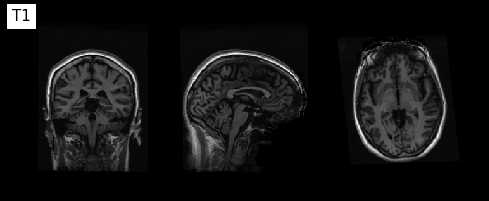

In [14]:
plotting.plot_epi(
    '/home/neuro/workshop/data/ds000114/derivatives/fmriprep/sub-01/anat/sub-01_t1w_preproc.nii.gz',
    title="T1", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

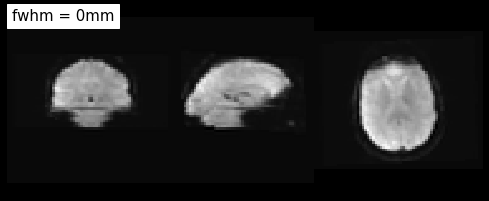

In [15]:
plotting.plot_epi(opj(out_path, 'sub-01_ses-test_task-fingerfootlips_bold_mean.nii.gz'),
                  title="fwhm = 0mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

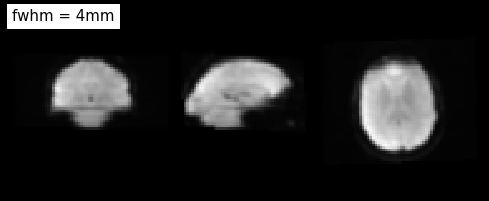

In [16]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-4_ssub-01_ses-test_task-fingerfootlips_bold.nii')),
                  title="fwhm = 4mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

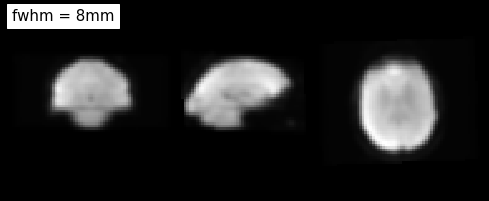

In [17]:
plotting.plot_epi(image.mean_img(opj(out_path, 'fwhm-8_ssub-01_ses-test_task-fingerfootlips_bold.nii')),
                  title="fwhm = 8mm", display_mode='ortho', annotate=False, draw_cross=False, cmap='gray');

Now, let's investigate the motion parameters. How much did the subject move and turn in the scanner?

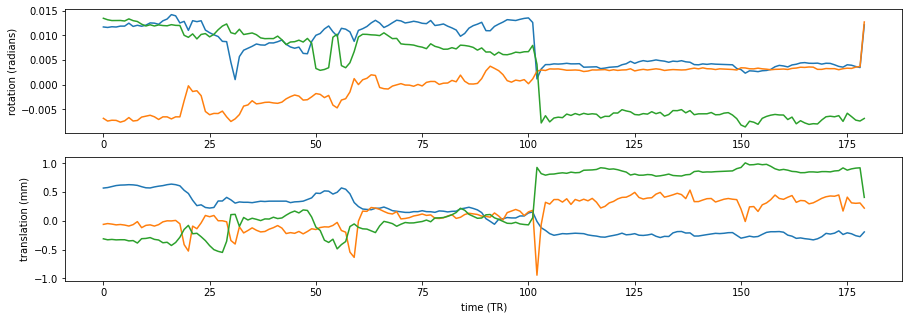

In [18]:
import numpy as np
import matplotlib.pyplot as plt
par = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/sub-01_ses-test_task-fingerfootlips_bold.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

There seems to be a rather drastic motion around volume 102. Let's check if the outliers detection algorithm was able to pick this up.

Outliers were detected at volumes: [ 59. 102.]


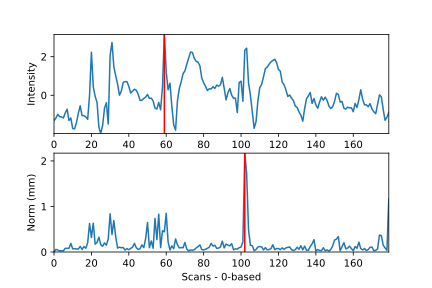

In [19]:
import numpy as np
outlier_ids = np.loadtxt('/output/datasink/preproc/sub-01/task-fingerfootlips/art.sub-01_ses-test_task-fingerfootlips_bold_outliers.txt')
print('Outliers were detected at volumes: %s' % outlier_ids)

from IPython.display import SVG
SVG(filename='/output/datasink/preproc/sub-01/task-fingerfootlips/plot.sub-01_ses-test_task-fingerfootlips_bold.svg')